# High-Frequency Grid Trading

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-updates-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-06-03-fefc6aa25e0947e2bf745c1c56bea13e">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

## Plain High-Frequency Grid Trading

This is a high-frequency version of Grid Trading that keeps posting orders on grids centered around the mid-price, maintaining a fixed interval and a set number of grids.

In [1]:
import numpy as np

from numba import njit, uint64, float64
from numba.typed import Dict

from hftbacktest import BUY, SELL, GTX, LIMIT

@njit
def gridtrading(hbt, recorder):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    grid_num = 20
    max_position = 5
    grid_interval = tick_size * 10
    half_spread = tick_size * 20

    # Running interval in nanoseconds.
    while hbt.elapse(100_000_000) == 0:
        # Clears cancelled, filled or expired orders.        
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)
        
        best_bid = depth.best_bid
        best_ask = depth.best_ask
        
        mid_price = (best_bid + best_ask) / 2.0

        order_qty = 0.1 # np.round(notional_order_qty / mid_price / hbt.depth(asset_no).lot_size) * hbt.depth(asset_no).lot_size
        
        # Aligns the prices to the grid.
        bid_price = np.floor((mid_price - half_spread) / grid_interval) * grid_interval
        ask_price = np.ceil((mid_price + half_spread) / grid_interval) * grid_interval

        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price): # position * mid_price < max_notional_position
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price): # position * mid_price > -max_notional_position
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        recorder.record(hbt)
    return True

For generating order latency from the feed data file, which uses feed latency as order latency, please see [Order Latency Data](https://hftbacktest.readthedocs.io/en/latest/tutorials/Order%20Latency%20Data.html).

In [2]:
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest, Recorder

asset = (
    BacktestAsset()
        .data([
            'data/ethusdt_20221003.npz',
            'data/ethusdt_20221004.npz',
            'data/ethusdt_20221005.npz',
            'data/ethusdt_20221006.npz',
            'data/ethusdt_20221007.npz'
        ])
        .initial_snapshot('data/ethusdt_20221002_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency([
            'latency/feed_latency_20221003.npz',
            'latency/feed_latency_20221004.npz',
            'latency/feed_latency_20221005.npz',
            'latency/feed_latency_20221006.npz',
            'latency/feed_latency_20221007.npz'
        ])
        .power_prob_queue_model(2.0) 
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.01)
        .lot_size(0.001)
        .roi_lb(0.0)    
        .roi_ub(3000.0)
)
hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 5_000_000)

In [3]:
%%time
gridtrading(hbt, recorder.recorder)

_ = hbt.close()

CPU times: user 6min 5s, sys: 9.08 s, total: 6min 15s
Wall time: 6min 16s


In [4]:
from hftbacktest.stats import LinearAssetRecord

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=10_000)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-10-03 00:00:00,2022-10-07 23:59:50,18.265693,25.144025,0.082691,0.021906,9489.819672,127.266294,3.774836,0.00013,9140.288


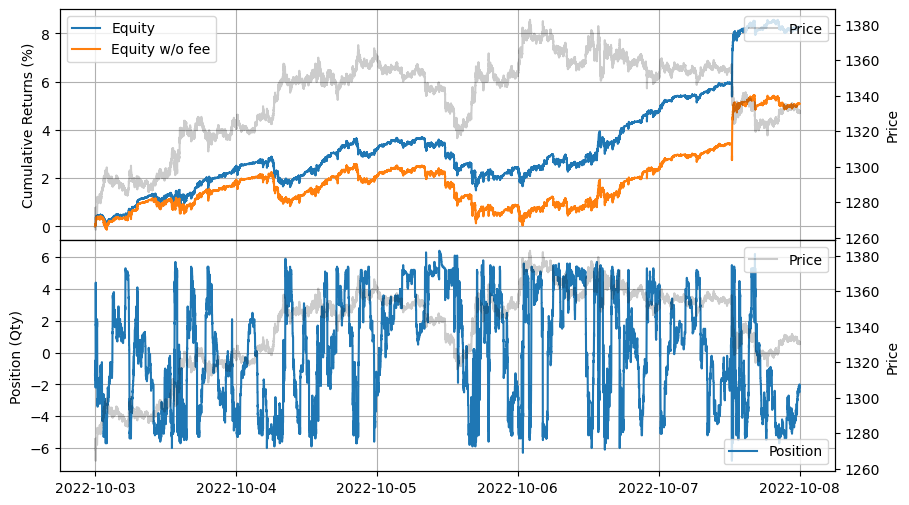

In [5]:
stats.plot()

## High-Frequency Grid Trading with Skewing

By incorporating position-based skewing, the strategy's risk-adjusted returns can be improved.

In [6]:
@njit
def gridtrading(hbt, recorder, skew):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    grid_num = 20
    max_position = 5
    grid_interval = tick_size * 10
    half_spread = tick_size * 20

    # Running interval in nanoseconds.
    while hbt.elapse(100_000_000) == 0:
        # Clears cancelled, filled or expired orders.        
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)
        
        best_bid = depth.best_bid
        best_ask = depth.best_ask
        
        mid_price = (best_bid + best_ask) / 2.0
        
        order_qty = 0.1 # np.round(notional_order_qty / mid_price / hbt.depth(asset_no).lot_size) * hbt.depth(asset_no).lot_size
        
        # The personalized price that considers skewing based on inventory risk is introduced, 
        # which is described in the well-known Stokov-Avalleneda market-making paper.
        # https://math.nyu.edu/~avellane/HighFrequencyTrading.pdf
        reservation_price = mid_price - skew * tick_size * position

        # Since our price is skewed, it may cross the spread. To ensure market making and avoid crossing the spread, 
        # limit the price to the best bid and best ask.
        bid_price = np.minimum(reservation_price - half_spread, best_bid)
        ask_price = np.maximum(reservation_price + half_spread, best_ask)

        # Aligns the prices to the grid.
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price): # position * mid_price < max_notional_position
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price): # position * mid_price > -max_notional_position
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        recorder.record(hbt)
    return True

### Weak skew

In [7]:
hbt = ROIVectorMarketDepthBacktest([asset])

skew = 1

recorder = Recorder(1, 5_000_000)

gridtrading(hbt, recorder.recorder, skew)

hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=10_000)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-10-03 00:00:00,2022-10-07 23:59:50,18.363916,25.321583,0.060482,0.014831,10563.644529,141.707178,4.077966,0.000085,9409.12


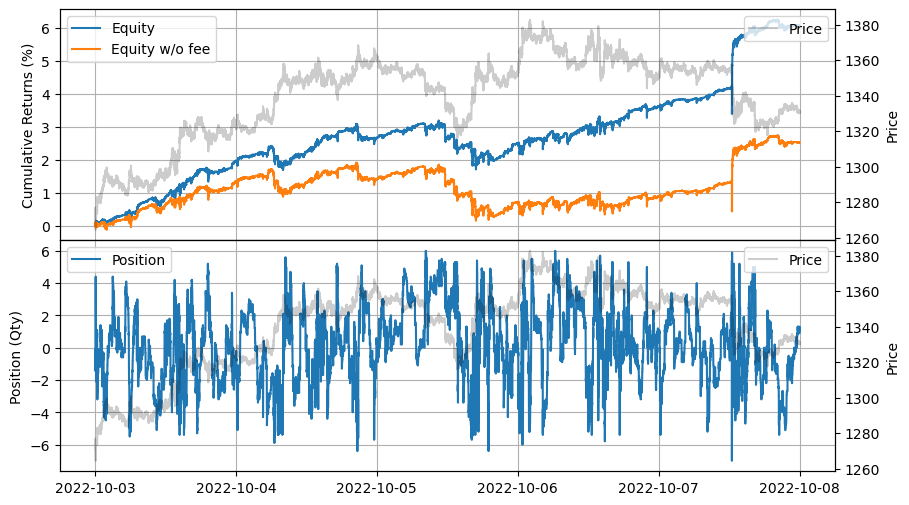

In [8]:
stats.plot()

### Strong skew
Under strong skew, the position is more limited compared to the weak skew case. You may also observe a spike in equity when the market moves sharply. However, in reality, this might not be realized due to order latency. Later, we will explore the impact of order latency and highlight the importance of using actual historical order latency data.

In [9]:
hbt = ROIVectorMarketDepthBacktest([asset])

skew = 10

recorder = Recorder(1, 5_000_000)

gridtrading(hbt, recorder.recorder, skew)

hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=10_000)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-10-03 00:00:00,2022-10-07 23:59:50,27.282302,47.25453,0.042574,0.005391,11838.874048,158.842253,7.897853,0.000054,8270.01


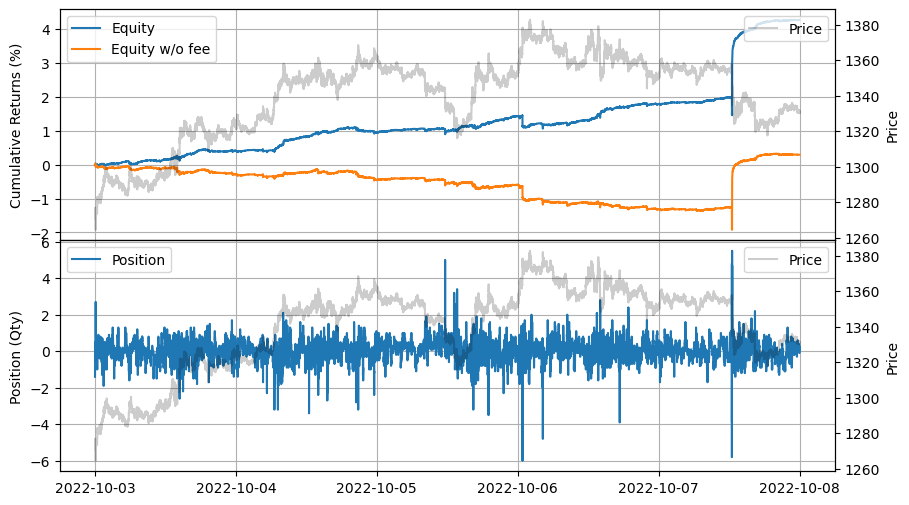

In [10]:
stats.plot()

## Multiple Assets

You might need to find the proper parameters for each asset to achieve better performance. As an example, here it uses single parameters set to demonstrate how the performance of a combination of multiple assets will be.

In [11]:
@njit
def gridtrading(hbt, recorder, half_spread, grid_interval, skew, order_qty):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    grid_num = 20
    max_position = grid_num * order_qty
        
    # Running interval in nanoseconds.
    while hbt.elapse(100_000_000) == 0:       
        # Clears cancelled, filled or expired orders.        
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        
        mid_price = (best_bid + best_ask) / 2.0

        normalized_position = position / order_qty

        # The personalized price that considers skewing based on inventory risk is introduced, 
        # which is described in the well-known Stokov-Avalleneda market-making paper.
        # https://math.nyu.edu/~avellane/HighFrequencyTrading.pdf
        reservation_price = mid_price - skew * normalized_position

        # Since our price is skewed, it may cross the spread. To ensure market making and avoid crossing the spread, 
        # limit the price to the best bid and best ask.
        bid_price = np.minimum(reservation_price - half_spread, best_bid)
        ask_price = np.maximum(reservation_price + half_spread, best_ask)

        # Ensures the grid interval aligns with the tick size, with the minimum set to the tick size.
        grid_interval = max(np.round(grid_interval / tick_size) * tick_size, tick_size)

        # Aligns the prices to the grid.
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price): # position * mid_price < max_notional_position
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price): # position * mid_price > -max_notional_position
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        recorder.record(hbt)
    return True

In [12]:
from hftbacktest import BUY_EVENT, SELL_EVENT

latency_data = np.concatenate(
    [np.load('latency/live_latency_{}.npz'.format(date))['data'] for date in range(20230701, 20230732)]
)
    
def backtest(args):
    asset_name, asset_info = args

    # Obtains the mid-price of the assset to determine the order quantity.
    snapshot = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0
    
    asset = (
        BacktestAsset()
            .data(['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)])
            .initial_snapshot('data/{}_20230630_eod.npz'.format(asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .log_prob_queue_model2() 
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.00005, 0.0007)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0)
            .roi_ub(mid_price * 5)
    )
    hbt = ROIVectorMarketDepthBacktest([asset])

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid_price) / asset_info['lot_size']), 1) * asset_info['lot_size']

    half_spread = mid_price * 0.0008
    grid_interval = mid_price * 0.0008
    skew = mid_price * 0.000025

    recorder = Recorder(1, 50_000_000)
    
    gridtrading(hbt, recorder.recorder, half_spread, grid_interval, skew, order_qty)

    hbt.close()

    recorder.to_npz('stats/gridtrading_{}.npz'.format(asset_name))

In [13]:
%%capture

import json
from multiprocessing import Pool

with open('assets.json', 'r') as f:
    assets =  json.load(f)

with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

In [14]:
import polars as pl
from hftbacktest.stats import LinearAssetRecord

equity_values = {}
for asset_name in assets.keys():
    data = np.load('stats/gridtrading_{}.npz'.format(asset_name))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )

    equity = stats.entire.with_columns(
        (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
    ).select(['timestamp', 'equity'])
    equity_values[asset_name] = equity

Text(0, 0.5, 'Cumulative Returns (%)')

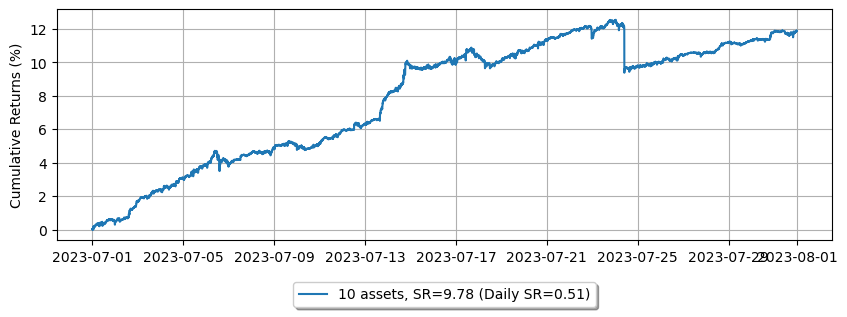

In [15]:
from matplotlib import pyplot as plt

fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity['equity'].clone()
    else:
        net_equity += equity['equity'].clone()

    if asset_number % 10 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_df = pl.DataFrame({
            'cum_ret': (net_equity / asset_number) / 2_000 * 100,
            'timestamp': equity['timestamp']
        })
        net_equity_rs_df = net_equity_df.group_by_dynamic(
            index_column='timestamp',
            every='1d'
        ).agg([
            pl.col('cum_ret').last()
        ])
        pnl = net_equity_rs_df['cum_ret'].diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)

        plt.plot(net_equity_df['timestamp'], net_equity_df['cum_ret'])
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')